<a href="https://colab.research.google.com/github/adilabduakhanov/Developing_Neuro-Employees_on_GPT/blob/main/%D0%98%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BA%D0%BE%D0%BD%D1%82%D1%83%D1%80%D0%BD%D1%8B%D1%85_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 16.6 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

MODEL_NAME = "IlyaGusev/saiga_yandexgpt_8b"

print("Загружаем модель...")

# Конфигурация 4-bit (самый стабильный вариант для Colab T4)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto"
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print("Модель успешно загружена!")

Загружаем модель...


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

Модель успешно загружена!


In [ ]:
def ask_saiga(question, history=None):
    if history is None:
        history = []

    messages = [
        {
            "role": "system",
            "content": "Ты — Сайга, русскоязычный автоматический ассистент. Ты разговариваешь с людьми и помогаешь им."
        }
    ]

    # добавляем историю диалога
    messages.extend(history)

    # добавляем текущий вопрос
    messages.append({
        "role": "user",
        "content": question
    })

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=512,
            temperature=0.7,
            top_p=0.9,
            do_sample=True
        )

    response = tokenizer.decode(
        output[0][inputs["input_ids"].shape[-1]:],
        skip_special_tokens=True
    )

    return response.strip()

In [ ]:
questions = [
    "Почему небо голубое?",
    "Объясни простыми словами, что такое машинное обучение",
    "Сочини короткий рассказ про мальчика и робота"
]

for q in questions:
    print("Вопрос:", q)
    answer = ask_saiga(q)
    print("Ответ:", answer)
    print("="*50)

Вопрос: Почему небо голубое?
Ответ: Небо кажется нам голубым из-за процесса рассеивания света в атмосфере Земли. Этот процесс называется "рассеиванием Рэлея". Когда солнечный свет попадает в атмосферу, он сталкивается с молекулами газов (в основном азота и кислорода), которые ведут себя как крошечные частицы. Эти молекулы сильнее всего взаимодействуют со светом короткой волны, таким как голубой цвет. В результате эти лучи света отклоняются во все стороны, создавая иллюзию голубого неба. 

Когда солнце находится низко над горизонтом (например, на рассвете или закате), мы видим больше красного и оранжевого цвета, потому что этот свет меньше рассеивается при прохождении через толщу атмосферы. Это явление также известно как красное сияние заката.
Вопрос: Объясни простыми словами, что такое машинное обучение
Ответ: Машинное обучение - это как учить компьютер делать то, чему обычно учат людей. Представь, что ты хочешь научить ребенка распознавать животных на картинках: покажи ему много разны

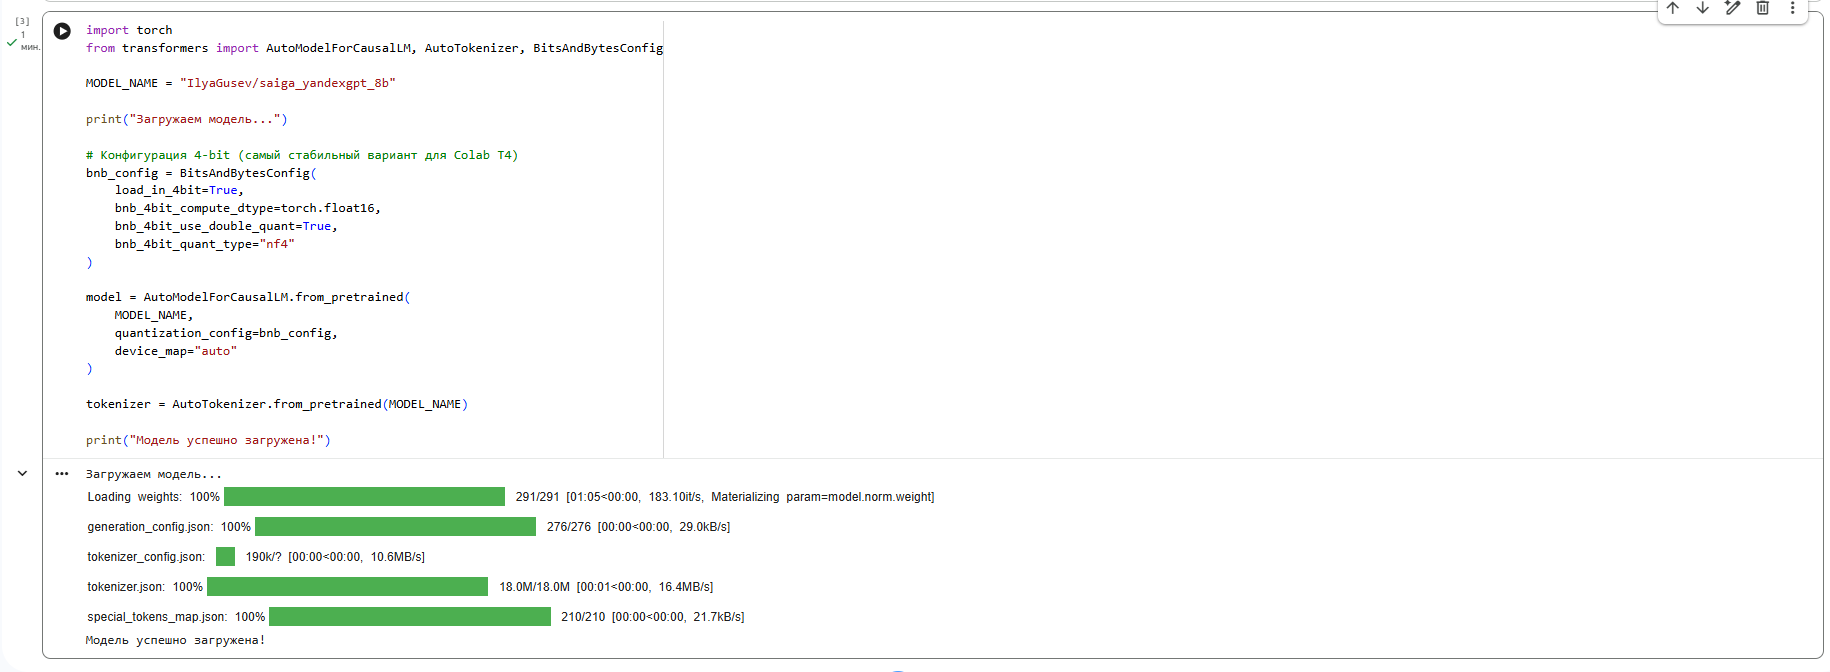

В ходе выполнения задания была запущена модель IlyaGusev/saiga_yandexgpt_8b
с использованием 4-bit квантования (BitsAndBytesConfig) на GPU T4 в Google Colab.

Модель протестирована в режиме диалога на трёх типах запросов:
1) Фактологический вопрос
2) Объяснение понятия
3) Творческая генерация текста

Модель корректно формирует осмысленные ответы на русском языке,
следует инструкциям и демонстрирует стабильную работу в режиме генерации текста.

In [ ]:
history = []

q1 = "Привет, кто ты?"
a1 = ask_saiga(q1, history)
history.append({"role": "user", "content": q1})
history.append({"role": "assistant", "content": a1})
print(a1)

q2 = "Чем ты можешь быть полезен?"
a2 = ask_saiga(q2, history)
print(a2)

Здравствуйте! Я Сайга — ваш автоматический помощник для общения на русском языке. Как я могу помочь вам сегодня? 😊
Я могу ответить на вопросы, дать советы по разным темам: от погоды до науки и технологий, помочь в поиске информации, рассказать о новостях или интересных фактах, а также просто поддержать беседу. Если у вас есть конкретные задачи или интересы, пожалуйста, сообщите мне об этом, и я постараюсь максимально эффективно выполнить вашу просьбу! 🔍💬💡
